# Particle identification and energy regression

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb

## Load dataframe

In [2]:
# DATA_DIR = '/groups/hep/mojen/repositories/DREAM/Run/final_run/tauolaevts/10000'
DATA_DIR = '/home/jupyter/DREAM'
df = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
print(f"df.shape : {df.shape}")
df.head()

df.shape : (39722, 15)


,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj
0,0,0,1,19816.199882,1825.8025,0.0000,5.811312,NaN,0.042815,NaN,0.000000,2527.482714,1,194.160770,112.979410
1,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362
2,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139
3,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179
4,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211


In [3]:
df['label_binary'] = df.label.map({0: 0, 1: 1, 2: 0, 3: 1})

In [4]:
df.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,label_binary
0,0,0,1,19816.199882,1825.8025,0.0000,5.811312,NaN,0.042815,NaN,0.000000,2527.482714,1,194.160770,112.979410,1
1,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,1
2,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,0
3,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,0
4,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,0


<!-- Add column with reconstructed energy -->

In [5]:
# cal = np.load(os.path.join(DATA_DIR, "calibration.pkl.npy"), allow_pickle=True).item()

In [6]:
# df['rec_energy'] = df.apply(lambda x: (x.S_sum-cal['chi']*x.C_sum)/(1-cal['chi']), axis=1)

In [7]:
# print(f"df.shape : {df.shape}")
# df.head()

## Train-test split

Train-test split by event id such that data leakage is avoided and decay classification is possible

In [8]:
unique_eventId = df.eventId.unique()

In [9]:
get_mode = lambda x: x.iloc[0].PrimaryDecayMode.astype(int)
mode_per_eventId = df.groupby('eventId').apply(get_mode).values

In [10]:
id_train, id_test = train_test_split(unique_eventId,
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify=mode_per_eventId)

Assert that id_train and id_test are mutually exclusive and in total have the same size as unique event id

In [11]:
assert len(set(id_train).intersection(set(id_test))) == 0

In [12]:
assert id_train.shape[0] + id_test.shape[0] == len(unique_eventId)

Split dataframe into a train and a test dataframe

In [13]:
excl_columns_y = ['eventId', 'PrimaryDecayMode', 'clusterId', 
                'VecShowerEnergy', 'label', 'label_binary', 
                  'comi', 'comj', 'S_sum', 'C_sum', 'rec_energy']
excl_columns_z = ['eventId', 'PrimaryDecayMode', 'clusterId', 
                'VecShowerEnergy', 'label', 'label_binary', 'comi', 'comj']

# train dataset
df_train = df[df.eventId.isin(id_train)].copy()
df_train.to_csv(os.path.join(DATA_DIR, 'dftrain.csv'), index=False)
y_train = df_train.label.values
z_train = df_train.VecShowerEnergy.values

df_train_y = df_train.drop(excl_columns_y, axis=1)
X_train_y = df_train_y.values
train_data_y = lgb.Dataset(X_train_y, label=y_train, feature_name=list(df_train_y.columns.values))

df_train_z = df_train.drop(excl_columns_z, axis=1)
X_train_z = df_train_z.values
train_data_z = lgb.Dataset(X_train_z, label=z_train, feature_name=list(df_train_z.columns.values))

# test data set
df_test = df[df.eventId.isin(id_test)].copy()
df_test.to_csv(os.path.join(DATA_DIR, 'dftest.csv'), index=False)
idx_test = df_test.clusterId.values.reshape((-1,1))
y_test = df_test.label.values
z_test = df_test.VecShowerEnergy.values

df_test_y = df_test.drop(excl_columns_y, axis=1)
X_test_y = df_test_y.values
test_data_y = lgb.Dataset(X_test_y, label=y_test, feature_name=list(df_test_y.columns.values))

df_test_z = df_test.drop(excl_columns_z, axis=1)
X_test_z = df_test_z.values
test_data_z = lgb.Dataset(X_test_z, label=z_test, feature_name=list(df_test_z.columns.values))

In [14]:
y_test

array([3, 2, 2, ..., 2, 2, 3])

In [15]:
print(f"features classification : {df_train_y.columns.values}")
print(f"features regression : {df_train_z.columns.values}")
assert set(df_train.columns.values) == set(df_test.columns.values)

features classification : ['S_rad_mean' 'C_rad_mean' 'S_hot' 'C_hot' 'CoverS']
features regression : ['S_sum' 'C_sum' 'S_rad_mean' 'C_rad_mean' 'S_hot' 'C_hot' 'CoverS'
 'rec_energy']


In [16]:
print(f"df_train.shape : {df_train.shape}")
print(f"df_test.shape : {df_test.shape}")

df_train.shape : (27761, 16)
df_test.shape : (11961, 16)


Assert that the length of the two dataframes equal the original

In [17]:
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

# Classification

(Boosted) decision trees 'unaffected' by feature scaling

### Training

In [18]:
params = {
    'num_class': [4],
    'objective': ['multiclass'],  # 'multiclassova'
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1, 0.05],  # default = 0.1
    'num_leaves': [31, 41, 21],  # default = 31
    'metric': ['multi_logloss']
}

In [19]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]
param

[{'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 41,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 21,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 31,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 41,
  'metric': 'multi_logloss'},
 {'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 21,
  'metric': 'multi_logloss'}]

In [20]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_y, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=False, seed=42)
    metric_name = param[i]['metric']+"-mean"
    results += [(i, len(cv_results[metric_name]), cv_results[metric_name][-1])]

In [21]:
results.sort(key=lambda x: x[2])
results

[(5, 263, 0.4824290820750778),
 (2, 126, 0.4825144180821683),
 (3, 192, 0.48320842804149455),
 (0, 97, 0.4838796281119574),
 (4, 168, 0.4846782473738414),
 (1, 85, 0.48605291404086703)]

In [22]:
param[results[0][0]]

{'num_class': 4,
 'objective': 'multiclass',
 'boosting': 'gbrt',
 'learning_rate': 0.05,
 'num_leaves': 21,
 'metric': 'multi_logloss'}

In [23]:
bst = lgb.train(param[results[0][0]], train_data_y, num_boost_round=results[0][1])

### Testing

In [24]:
y_pred = np.argmax(bst.predict(X_test_y), axis=1).reshape([-1,1])

In [33]:
confusion_matrix(y_test, y_pred, labels=[0,2,1,3])

array([[ 377, 1026,    2,    4],
       [ 270, 5793,   65,  165],
       [   2,  161,  355,  454],
       [  28,  176,  114, 2969]])

In [26]:
accuracy_score(y_test, y_pred)

0.7937463422790737

In [28]:
df_new = pd.DataFrame(np.hstack((idx_test, y_pred)), columns=['clusterId', 'predictedLabel'])
df_merged = df.merge(df_new, how='inner', on='clusterId')
df_merged

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,label_binary,predictedLabel
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,1,3
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,0,2
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,0,2
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,0,2
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,0.972478,1862.072820,2,157.373335,147.430044,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,24994,47843,4,23198.037915,20995.1740,20991.4730,2.688260,2.105588,0.180732,0.158891,0.999824,20996.596344,2,142.857341,152.197950,0,2
11957,24994,47844,4,5323.161134,4377.6500,4204.6826,2.252140,1.775723,0.135529,0.141350,0.960489,4444.123675,2,85.402598,125.760214,0,2
11958,24997,47850,3,1257.497641,1061.2260,1224.1480,1.792903,1.445399,0.127345,0.224638,1.153522,998.612906,2,111.476039,64.688250,0,2
11959,24997,47851,3,2065.989166,1842.0273,2102.3413,2.347781,2.146135,0.162746,0.172996,1.141319,1741.985163,2,183.128526,53.747914,0,2


In [29]:
df_merged['predictedLabel2'] = df_merged['predictedLabel']
df_merged.loc[((df_merged.label == 0) & (df_merged.predictedLabel2 == 2)), 'predictedLabel2'] = df_merged.label
df_merged.loc[((df_merged.label == 2) & (df_merged.predictedLabel2 == 0)), 'predictedLabel2'] = df_merged.label
df_merged.loc[((df_merged.label == 1) & (df_merged.predictedLabel2 == 3)), 'predictedLabel2'] = df_merged.label
df_merged.loc[((df_merged.label == 3) & (df_merged.predictedLabel2 == 1)), 'predictedLabel2'] = df_merged.label

In [32]:
confusion_matrix(y_test, df_merged.predictedLabel2, labels=[0,2,1,3])

array([[1403,    0,    2,    4],
       [   0, 6063,   65,  165],
       [   2,  161,  809,    0],
       [  28,  176,    0, 3083]])

In [31]:
accuracy_score(y_test, df_merged.predictedLabel2)

0.9495861550037622

In [32]:
df_merged.shape

(11961, 17)

In [33]:
df_merged.predictedLabel.isna().sum()

0

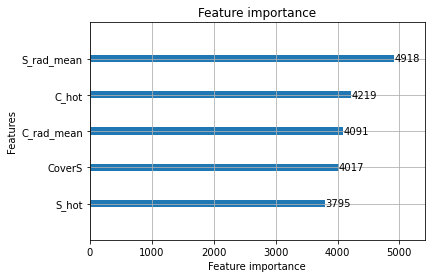

In [34]:
lgb.plot_importance(bst)

In [120]:
from sklearn.inspection import permutation_importance
model = lgb.LGBMClassifier(**param[results[0][0]], n_estimators=results[0][1])
model = model.fit(X_train, y_train)
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train_data_y.feature_name[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

C_rad_mean0.172 +/- 0.003
C_hot   0.065 +/- 0.002
S_rad_mean0.062 +/- 0.002
CoverS  0.057 +/- 0.002
C_sum   0.050 +/- 0.002
S_hot   0.027 +/- 0.001
rec_energy0.021 +/- 0.002
S_sum   0.015 +/- 0.001


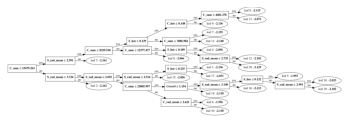

In [121]:
lgb.plot_tree(bst)

## Regression

### Training

In [34]:
params = {
    'objective': ['regression'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1, 0.05], # 0.01],  # default = 0.1
    'num_leaves': [31, 21, 41],  # default = 31
    'metric': ['mape'], # 'rmse']
}

In [35]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [36]:
param

[{'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 21,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 41,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 21,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.05,
  'num_leaves': 41,
  'metric': 'mape'}]

In [37]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_z, num_boost_round=1000, early_stopping_rounds=20, verbose_eval=False, seed=42, stratified=False)
    metric_name = param[i]['metric']+"-mean"
    results += [(i, len(cv_results[metric_name]), cv_results[metric_name][-1])]

In [38]:
results.sort(key=lambda x: x[2])
results

[(5, 280, 0.3251374166027817),
 (2, 134, 0.32767821370037686),
 (3, 370, 0.3300638374867154),
 (0, 199, 0.3313337137294589),
 (4, 551, 0.3332111111793291),
 (1, 222, 0.33615196904542693)]

In [40]:
param[results[0][0]]

{'objective': 'regression',
 'boosting': 'gbrt',
 'learning_rate': 0.05,
 'num_leaves': 41,
 'metric': 'mape'}

In [41]:
bst = lgb.train(param[results[0][0]], train_data_z, num_boost_round=results[0][1])

### Testing

In [42]:
z_pred = bst.predict(X_test_z).reshape([-1,1])

In [43]:
z_pred = np.clip(z_pred, 0, 1e6)

In [47]:
np.mean(np.abs((z_test.reshape([-1,1]) - z_pred) / z_test.reshape([-1,1]))) * 100

31.4220272968041

In [48]:
df_new2 = pd.DataFrame(np.hstack((idx_test, z_pred)), columns=['clusterId', 'predictedEnergy'])
df_merged2 = df_merged.merge(df_new2, how='inner', on='clusterId')
df_merged2.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,rec_energy,label,comi,comj,label_binary,predictedLabel,predictedLabel2,predictedEnergy
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,0.656293,7375.418953,3,124.308455,127.515362,1,3,3,15232.819549
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,0.765850,11375.182248,2,135.292237,180.123139,0,2,2,11212.475262
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,0.821498,5377.132679,2,150.901608,175.728179,0,2,2,5538.377130
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,1.039076,10502.665935,2,138.046102,156.708211,0,2,2,11999.057493
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,0.972478,1862.072820,2,157.373335,147.430044,0,2,2,2427.241780


In [49]:
df_merged2.to_csv(os.path.join(DATA_DIR, 'dfmerged2.csv'), index=False)

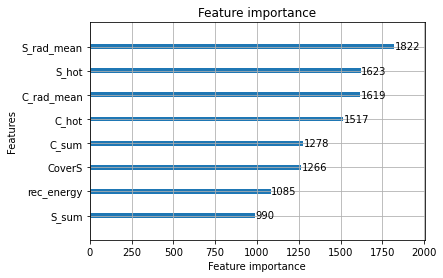

In [66]:
lgb.plot_importance(bst)

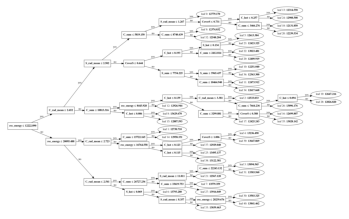

In [67]:
lgb.plot_tree(bst)

## Pion reconstruction

In [50]:
import itertools
from scipy import spatial

def pionReconstruction(df, label, energy):
    m_true = 134.9770
    df_gamma = df[df[label] == 2]
    if df_gamma.shape[0] >= 2:  # two or more photons
        indices = df_gamma.index.values
        pairs = list(map(list, itertools.combinations(indices, 2)))
        d = {'[]': m_true}
        for p in pairs:
            df_gamma_pair = df_gamma.loc[p]
            f1 = lambda x: np.sqrt((x.comi_mm-0)**2+(x.comj_mm-0)**2+(2500-0)**2)
            df_gamma_pair['vlen'] = df_gamma_pair.apply(f1, axis=1)
            num = df_gamma_pair.comi_mm.product() + df_gamma_pair.comj_mm.product() + 2500**2
            denom = df_gamma_pair.vlen.product()
            cos_theta = np.clip(num / denom, 0, 1)
            mass = np.sqrt(2*df_gamma_pair[energy].product()*(1-cos_theta))
            d[str(p)] = mass
        pair_of_pairs = list(map(list, itertools.combinations(pairs, 2)))

        p_lst = [p for p in pair_of_pairs if len(set(p[0]+p[1])) == 4]
        
        if len(p_lst) == 0:
            p_lst = [[pairs[0], []]]
        
        metric = []
        for p in p_lst:
            metric += [np.sqrt((d[str(p[0])]-m_true)**2 + (d[str(p[1])]-m_true)**2)]
        best_idx = np.argsort(metric)[0]
        
        for p in p_lst[best_idx]:
            if len(p) != 0:
                df.at[p[0], 'pair'] = p
                df.at[p[1], 'pair'] = p
                df.at[p[0], 'predicted_pi0_mass'] = d[str(p)]
                df.at[p[1], 'predicted_pi0_mass'] = d[str(p)]
        
    return df

In [51]:
df_merged2['comi_mm'] = df_merged2.apply(lambda x: 3*(x.comi-284+0.5), axis=1)
df_merged2['comj_mm'] = df_merged2.apply(lambda x: 3*(x.comj-284+0.5), axis=1)
df_merged2['pair'] = None
df_merged2['predicted_pi0_mass'] = None
df_merged3 = df_merged2.groupby('eventId').apply(lambda x: pionReconstruction(x, 'predictedLabel2', 'predictedEnergy'))

In [52]:
df_merged3.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,...,comi,comj,label_binary,predictedLabel,predictedLabel2,predictedEnergy,comi_mm,comj_mm,pair,predicted_pi0_mass
0,1,1,4,13397.354239,6514.8620,4275.6553,4.649778,3.531102,0.071061,0.058091,...,124.308455,127.515362,1,3,3,15232.819549,-477.574634,-467.953913,None,None
1,1,2,4,10115.048809,10436.0700,7992.4590,2.342874,1.656479,0.261235,0.188679,...,135.292237,180.123139,0,2,2,11212.475262,-444.623289,-310.130582,"[1, 2]",148.864
2,1,3,4,4740.947309,5031.9375,4133.7246,2.474634,2.093701,0.116771,0.190987,...,150.901608,175.728179,0,2,2,5538.377130,-397.795177,-323.315464,"[1, 2]",148.864
3,1,4,4,11594.263998,10662.7920,11079.4470,2.513136,1.768877,0.180327,0.168935,...,138.046102,156.708211,0,2,2,11999.057493,-436.361693,-380.375367,"[3, 4]",134.992
4,1,5,4,2466.543425,1842.5836,1791.8718,2.239413,1.640046,0.152792,0.247525,...,157.373335,147.430044,0,2,2,2427.241780,-378.379995,-408.209869,"[3, 4]",134.992


In [53]:
df_merged3.reset_index(drop=True, inplace=True)

In [54]:
df_merged4 = df_merged3.copy()
df_merged4 = df_merged4[["pair","predicted_pi0_mass"]].reset_index(drop=True)
df_merged4.pair = df_merged4.pair.astype('str')
df_merged4 = df_merged4.drop_duplicates()
df_merged4.to_csv(os.path.join(DATA_DIR, 'predicted_pi0_mass.csv'), index=False)

## Decay classification

In [55]:
def decayClassification(x, label):
    counts_label = x[label].value_counts()
    counts_pair = x.pair.unique() 
    num_pairs = len([p for p in counts_pair if p != 'None'])
    mode = np.nan
    if 0 in counts_label.keys():
        mode = 0
    elif 1 in counts_label.keys():
        mode = 1
    elif 3 in counts_label.keys() and num_pairs <= 2:
        mode = 2
        if num_pairs == 1:
            mode = 3
        elif num_pairs == 2:
            mode = 4
    elif 2 in counts_label.keys():
        mode = 5
    x['predictedPrimaryDecayMode'] = mode
    return x

In [56]:
df_merged3.pair = df_merged3.pair.astype("str")
df_merged5 = df_merged3.groupby('eventId').apply(lambda x: decayClassification(x, 'predictedLabel2'))

In [57]:
mode_per_eventId = df_merged5.groupby('eventId').apply(get_mode)
get_predmode = lambda x: x.iloc[0].predictedPrimaryDecayMode.astype(int)
predmode_per_eventId = df_merged5.groupby('eventId').apply(get_predmode)

In [58]:
matrix = pd.crosstab(mode_per_eventId, predmode_per_eventId,
                     rownames=['Actual'], colnames=['Predicted'])
print(matrix)

Predicted     0    1     2    3    4    5
Actual                                   
0          1403    2     4    0    0    0
1             2  809     0    0    0  161
2            12    0  1264    0    0   52
3             8   26   277  709    0  315
4             8   37    35  504  290  322


In [59]:
accuracy_score(mode_per_eventId, predmode_per_eventId)

0.7171474358974359